# Basic Regression
- A regression problem aims to predict the output of a continuous value whereas a classification problem aims to select a class from a list of classes.
- In this tutorial, the classic Auto MPG dataset is used to predict the fuel efficiency of late-1970s to early 1980s automobiles by building neural network models.
- Full tutorial reference: https://www.tensorflow.org/tutorials/keras/regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.1


### Auto MPG dataset

In [10]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_df = pd.read_csv(url, sep=' ', names=column_names, skipinitialspace=True, na_values='?', comment='\t')
df = raw_df.copy()
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Clean the data

In [11]:
# drop N/A values
df.dropna(inplace=True)

In [12]:
# The 'Origin' column is categorical, so we should one-hot encode the values in the column
df['Origin'] = df['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})
df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='')
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


### Split the data into training and testing dataset

In [14]:
train_ds = df.sample(frac=0.8, random_state=0)
test_ds = df.drop(train_ds.index)

### Inspect the data

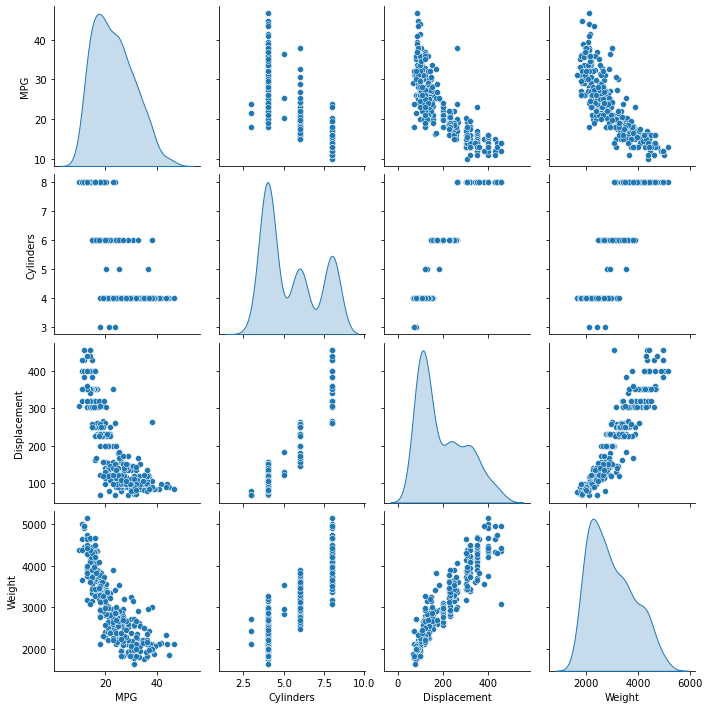

In [15]:
sns.pairplot(train_ds[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [16]:
train_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels
- Seperate the target value (label) from the features.

In [17]:
train_features = train_ds.copy()
test_features = test_ds.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Normalization

In [18]:
# create the normalization layer 
normalizer = tf.keras.layers.Normalization(axis=-1)

# fit the state of the preprocessing layer to the data by calling adapt function
normalizer.adapt(np.array(train_features))

### Linear regression with one variable
- A single-variable linear regression to predict 'MPG' from 'horsepower'. Apply a linear transformation *y = mx + b* to produce one output using a linear layer. 

In [20]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [21]:
# keras sequential model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [22]:
horsepower_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                         loss='mean_absolute_error')

In [23]:
history = horsepower_model.fit(train_features['Horsepower'],
                               train_labels,
                               epochs=100,
                               verbose=0, 
                               # calcuate validation results on 20% of the training data
                               validation_split=0.2)

In [30]:
# function from tutorial
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.grid(True)
    plt.legend()

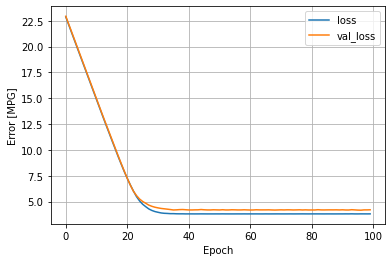

In [31]:
plot_loss(history)

In [38]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'],
                                                             test_labels,
                                                             verbose=0)

### Model's predictions

In [33]:
# function from tutorial
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

8/8 [==============================] - 0s 1ms/step


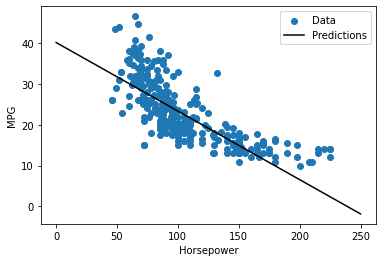

In [34]:
x = tf.linspace(0.0, 250.0, 251)
y = horsepower_model.predict(x)

plot_horsepower(x, y)

### Linear regression with multiple variables
- Multiple-variable linear regression to make predictions. This model does the same *y = mx + b* except that *m* is a matrix and *b* is a vector.

In [35]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])

linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
                     loss='mean_absolute_error')

In [36]:
history = linear_model.fit(train_features,
                           train_labels,
                           epochs=100,
                           verbose=0,
                           # calcuate validation results on 20% of the training data
                           validation_split=0.2)

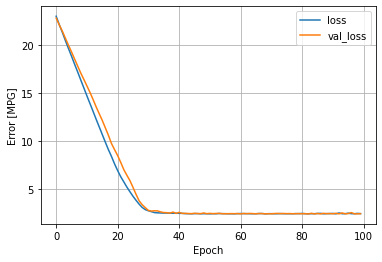

In [37]:
plot_loss(history)

In [39]:
test_results['linear_model'] = linear_model.evaluate(test_features,
                                                     test_labels,
                                                     verbose=0)

### Regression with a single input DNN (Deep Neural Network)
- DNN model contains a few more layers:
    - Normalization layer
    - Two hidden, non-linear, Dense layer with the ReLU activation function
    - A linear Dense single-output layer

In [47]:
# function from tutorial
def build_dnn_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(64, activation='relu'), # relu activation function
        tf.keras.layers.Dense(64, activation='relu'), # relu activation function
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_absolute_error')
    return model

In [42]:
dnn_horsepower_model = build_dnn_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [43]:
history = dnn_horsepower_model.fit(train_features['Horsepower'],
                                   train_labels,
                                   epochs=100,
                                   verbose=0,
                                   validation_split=0.2)

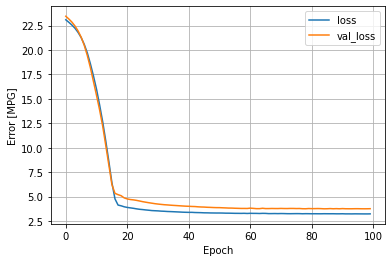

In [44]:
plot_loss(history)

8/8 [==============================] - 0s 2ms/step


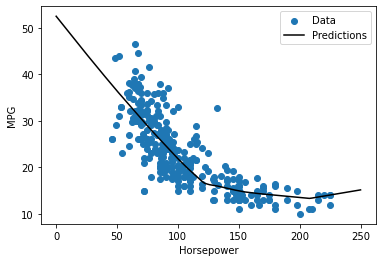

In [45]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [46]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'],
                                                                     test_labels,
                                                                     verbose=0)

### Regression with multiple inputs DNN (Deep Neural Network)
- Building model is almost identical to the previous model. 

In [48]:
dnn_model = build_dnn_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 64)                640       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [49]:
history = dnn_model.fit(train_features,
                        train_labels,
                        epochs=100,
                        verbose=0,
                        validation_split=0.2)

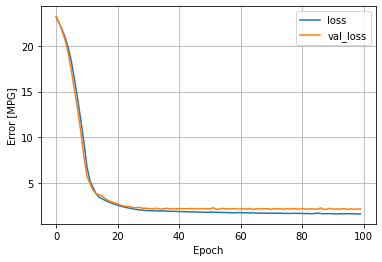

In [50]:
plot_loss(history)

In [51]:
test_results['dnn_model'] = dnn_model.evaluate(test_features,
                                               test_labels,
                                               verbose=0)

### Performance / Predictions

In [52]:
pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).transpose()

,Mean Absolute Error [MPG]
horsepower_model,3.654034
linear_model,2.500979
dnn_horsepower_model,2.894415
dnn_model,1.709902


3/3 [==============================] - 0s 5ms/step


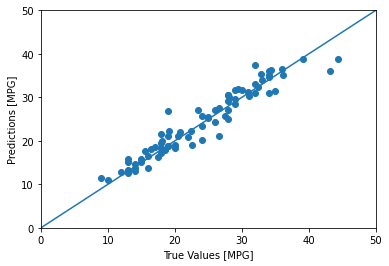

In [59]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()

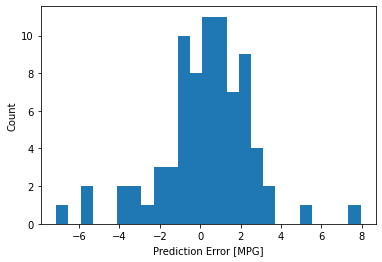

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')
plt.show()

### Save the model

In [60]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [61]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.